In [76]:
from __future__ import division, print_function
import numpy as np
from numpy import (arange, pi, zeros)
import scipy as sp
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import display, Audio
plt.style.use('bmh')
%matplotlib inline

In [77]:
#load the data
fs, cheese = wavfile.read(r"C:\Users\pabdu\Desktop\Tool box for degradation and evaluation\Testing STM and Noise vocoding\original_wav\BreakingBad_3_E1.wav")
#normalization of the wavfile if needed
cheese = cheese[:,0]
cheese = (1/max(cheese)) * cheese

cheese = cheese.astype('float')

C:\Users\pabdu\AppData\Local\Temp\ipykernel_23860\1281024135.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, cheese = wavfile.read(r"C:\Users\pabdu\Desktop\Tool box for degradation and evaluation\Testing STM and Noise vocoding\original_wav\BreakingBad_3_E1.wav")


In [79]:
def third_octave_bounds(cf):
    third_octave_ratio = 2 ** (1/6)  # 2 * 1/6 = 1/3
    return np.array([cf / third_octave_ratio, cf * third_octave_ratio])

def log_spaced_frequencies(low, high, num_bands):
    center_frequencies = np.logspace(np.log2(low), np.log2(high), num=num_bands, base=2)
    bounds = [third_octave_bounds(cf) for cf in center_frequencies]
    return bounds

def design_filter(bounds, fs):
    low, high = bounds
    nyquist = 0.5 * fs
    low_cutoff = low / nyquist
    high_cutoff = high / nyquist
    return sp.signal.butter(2, [low_cutoff, high_cutoff], btype='bandpass')

def apply_filterbank(x, center_frequencies, fs):
    n_samples = x.shape[-1]
    n_channels = len(center_frequencies)
    
    coefficients = [design_filter(bounds, fs) for bounds in center_frequencies]
    y = np.zeros((n_channels, n_samples))
    for idx, (b, a) in enumerate(coefficients):
        y[idx] = lfilter(b, a, x)
    return y

def extract_envelope(x, cutoff=20, order=1):
    envelope = np.abs(x)
    b, a = sp.signal.butter(order, cutoff * 2 / fs)
    low_pass_filtered_envelope = sp.signal.lfilter(b, a, envelope)
    return low_pass_filtered_envelope

def plot_signal_and_envelope(x, envelope, fs):
    fig, ax = plt.subplots()
    t = np.arange(x.shape[-1]) / fs
    ax.plot(t, x, label='signal')
    ax.plot(t, envelope, label='envelope')
    ax.legend(loc='best')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    
def vocode(x, center_frequencies, fs):
    n_channels = len(center_frequencies)
    n_samples = x.shape[-1]
    noise = np.random.randn(n_samples)

    filtered_x = apply_filterbank(x, center_frequencies, fs)
    filtered_noise = apply_filterbank(noise, center_frequencies, fs)
    
    vocoded_noise = np.zeros((n_channels, n_samples))
    for idx, (x_band, noise_band) in enumerate(zip(filtered_x, filtered_noise)):
        envelope = extract_envelope(x_band)
        vocoded_noise[idx] = envelope * noise_band
    return np.sum(vocoded_noise, axis=0)


def compare_spectrogram(x, y, fs):
    """Plots spectrogram of x, the original, and y, the modified signal."""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

    p_x, *_, im  = axes[0].specgram(x, cmap='brg', Fs=fs)
    vmin, vmax = 10 * np.log10([np.min(p_x), np.max(p_x)])
    _ = axes[1].specgram(y, cmap='brg', Fs=fs, vmin=vmin, vmax=vmax)
    axes[0].set_title('Original')
    axes[1].set_title('Vocoded')
    for ax in axes:
        ax.set_xlabel('Time (s)')
        ax.grid(False)
    axes[0].set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(im)
    cbar.ax.set_ylabel('Magnitude (dB)')
    fig.tight_layout()




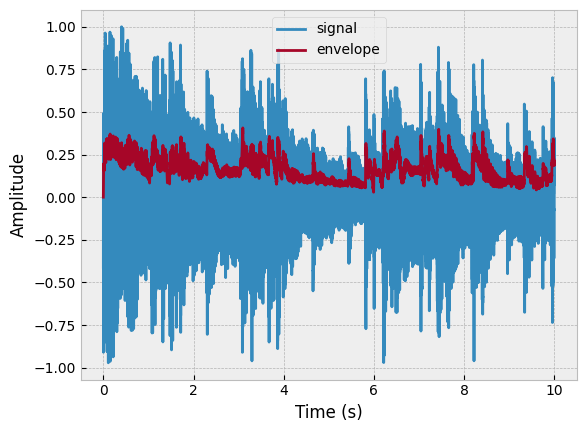

In [80]:
envelope = extract_envelope(cheese)

plot_signal_and_envelope(cheese, envelope, fs)

In [81]:
Audio(envelope,rate=fs)

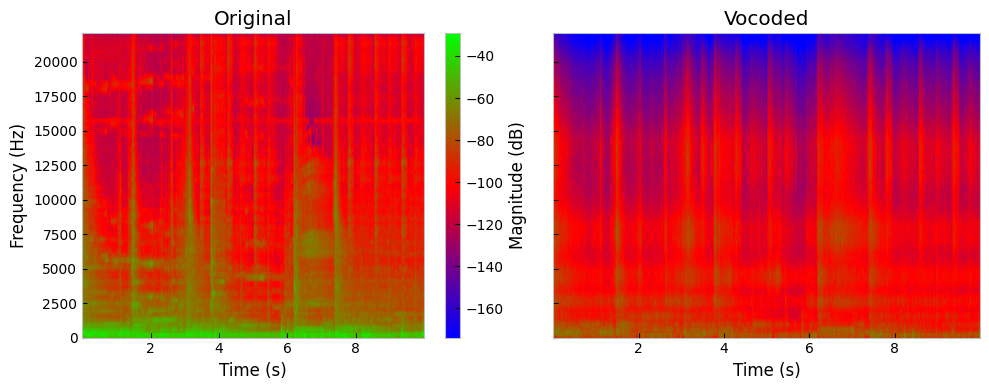

In [84]:
# Log-spaced center frequencies for the bands
num_bands = 10  # You can adjust the number of bands as needed
low_freq = 100
high_freq = 12810
center_frequencies = log_spaced_frequencies(low_freq, high_freq, num_bands)

# Perform noise vocoding using log-spaced bands
vocoded_cheese = vocode(cheese, center_frequencies, fs)

# Save the vocoded output as a WAV file
output_path = r'C:\Users\pabdu\Desktop\vocoded_output_log_spaced.wav'
sf.write(output_path, vocoded_cheese, samplerate=fs)

compare_spectrogram(cheese, vocoded_cheese, fs)

# Play the vocoded audio
Audio(vocoded_cheese, rate=fs)


In [85]:
#listen to one band

Audio(filtered_x[10], rate=fs)

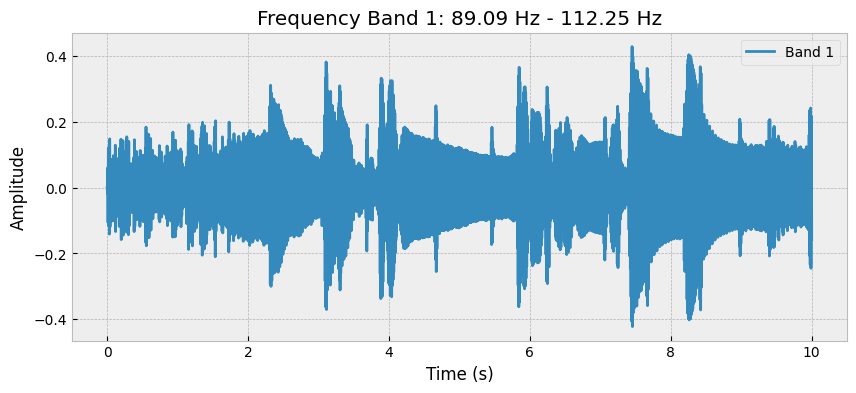

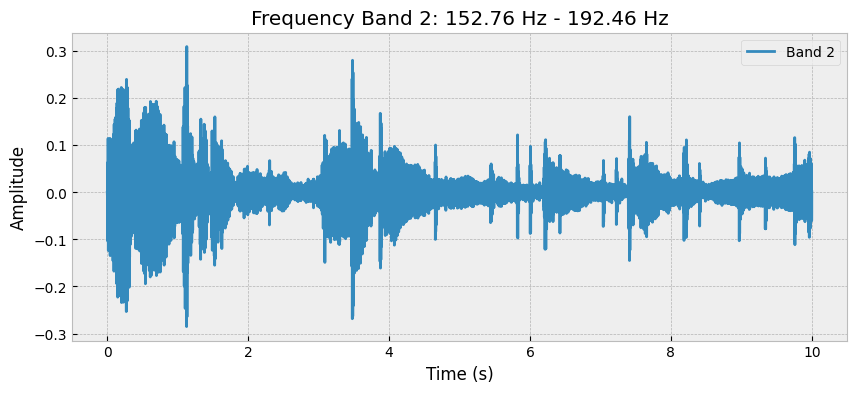

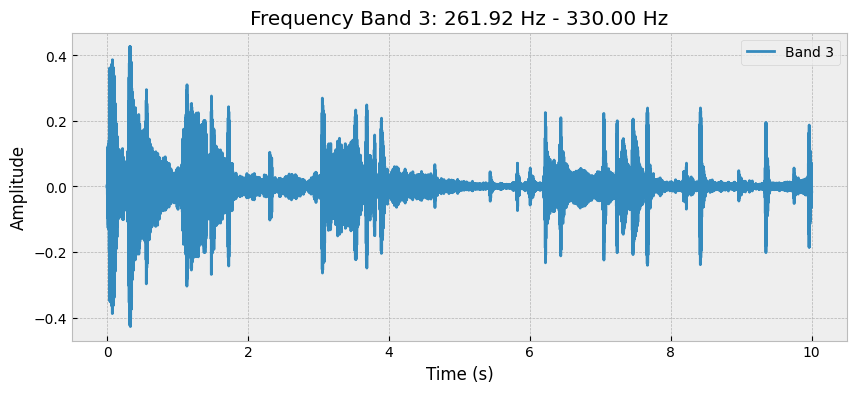

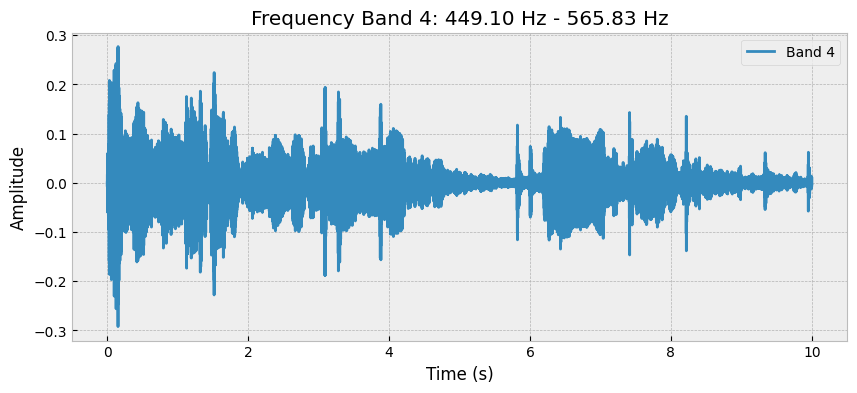

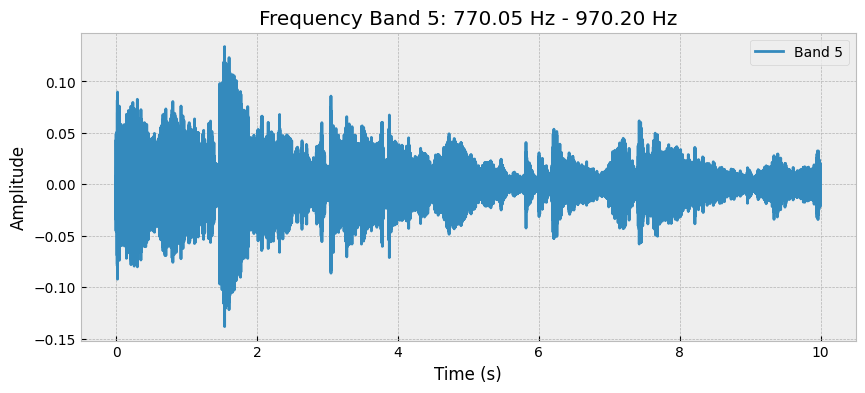

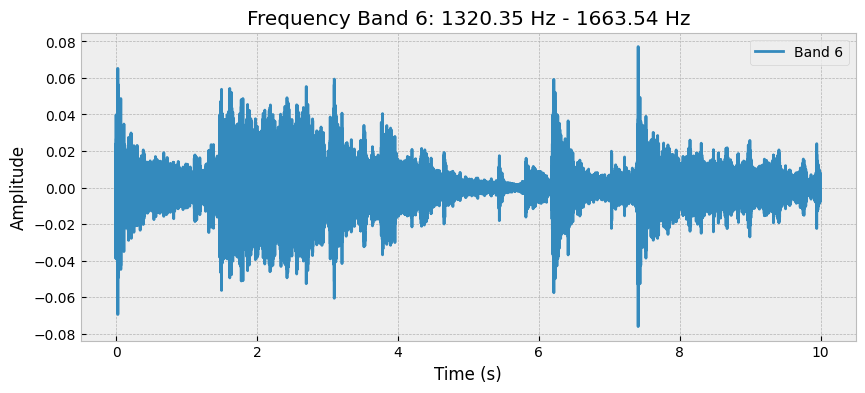

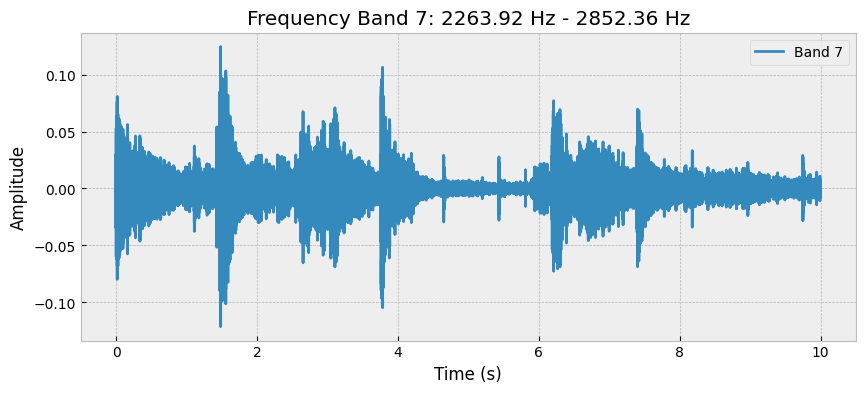

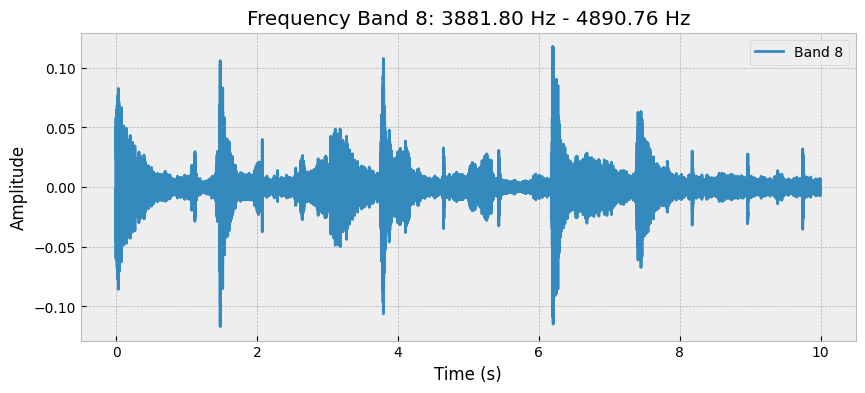

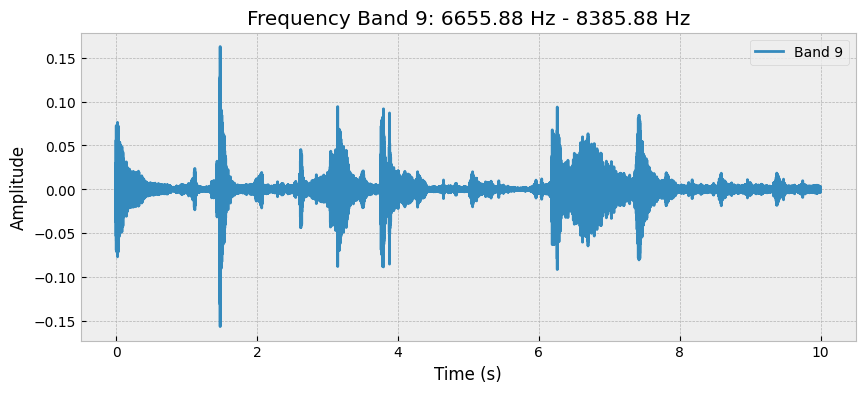

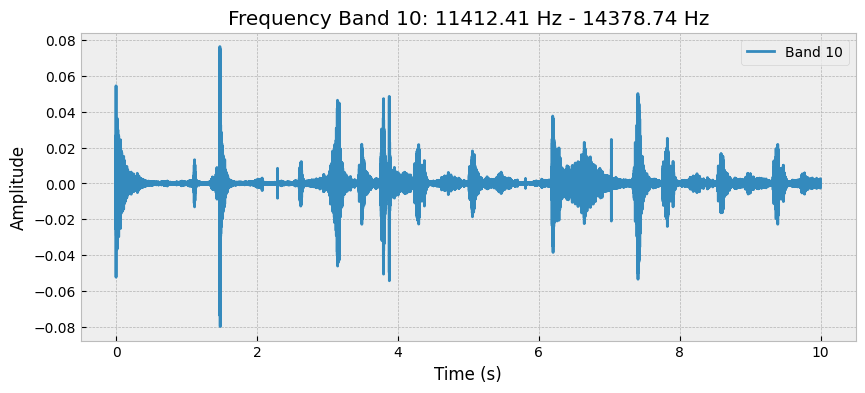

In [86]:
def plot_filtered_x_and_play(filtered_x, center_frequencies, fs):
    num_bands, n_samples = filtered_x.shape
    t = np.arange(n_samples) / fs

    for band_idx in range(num_bands):
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        ax.plot(t, filtered_x[band_idx], label=f'Band {band_idx + 1}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.legend()
        
        # Add frequency information to the title
        freq_range = center_frequencies[band_idx]
        plt.title(f'Frequency Band {band_idx + 1}: {freq_range[0]:.2f} Hz - {freq_range[1]:.2f} Hz')
        plt.show()

# Usage:
filtered_x = apply_filterbank(cheese, center_frequencies, fs)
plot_filtered_x_and_play(filtered_x, center_frequencies, fs)



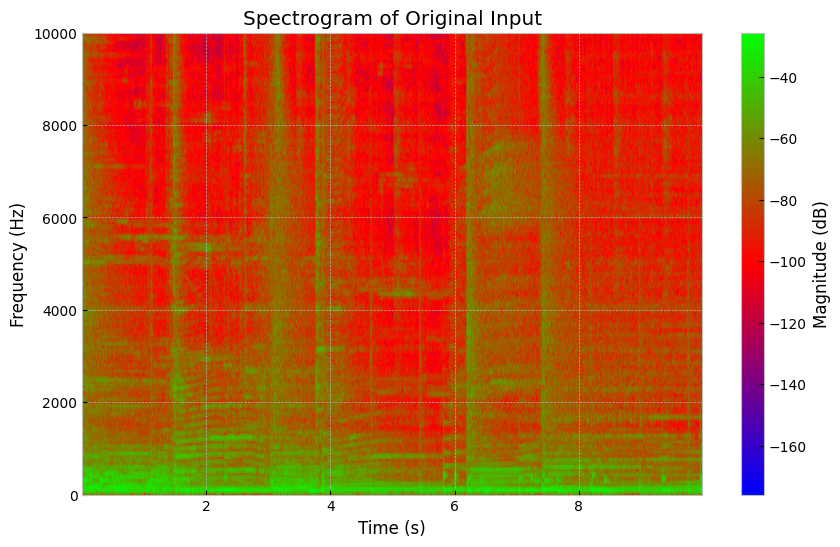

In [87]:
# Plot the spectrogram of the original input
plt.figure(figsize=(10, 6))
plt.specgram(cheese, Fs=fs, cmap='brg', NFFT=1024, noverlap=512)
plt.title('Spectrogram of Original Input')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Magnitude (dB)')
plt.ylim(0,10000)
plt.show()


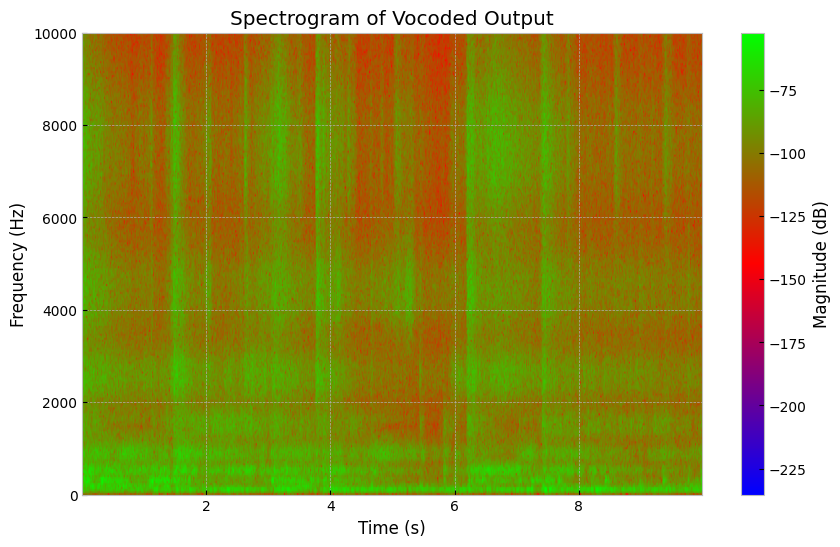

In [88]:
vocoded_cheese = vocode(cheese, center_frequencies, fs)

# Plot the spectrogram of the vocoded output
plt.figure(figsize=(10, 6))
plt.specgram(vocoded_cheese, Fs=fs, cmap='brg', NFFT=1024, noverlap=512)
plt.title('Spectrogram of Vocoded Output')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Magnitude (dB)')
plt.ylim(0,10000)
plt.show()

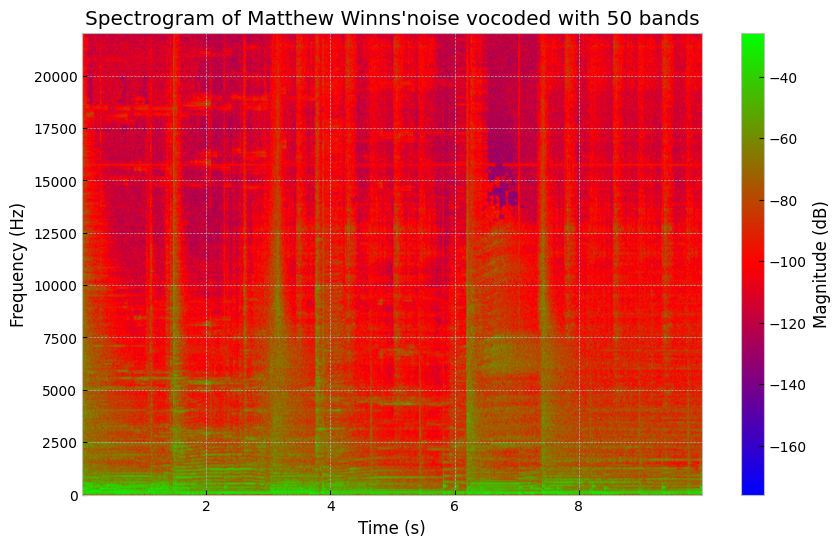

In [71]:
# Plot the spectrogram of the original output

plt.figure(figsize=(10, 6))
plt.specgram(cheese, Fs=fs, cmap='brg', NFFT=1024, noverlap=512)
plt.title('Spectrogram of Matthew Winns\'noise vocoded with 50 bands')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Magnitude (dB)')
plt.show()